In [1]:
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
from IPython.display import Image, display 
import seaborn as sns
import torch
from sklearn import model_selection, metrics, preprocessing
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from numpy.linalg import svd
from scipy.sparse import coo_matrix
import itertools

In [3]:
df = pd.read_csv('beer_reviews.csv')

In [4]:
df.head(10)

,index,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215
3,3,10325,Vecchio Birraio,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969
4,4,1075,Caldera Brewing Company,1293735206,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883
5,5,1075,Caldera Brewing Company,1325524659,3.0,3.5,3.5,oline73,Herbed / Spiced Beer,3.0,3.5,Caldera Ginger Beer,4.7,52159
6,6,1075,Caldera Brewing Company,1318991115,3.5,3.5,3.5,Reidrover,Herbed / Spiced Beer,4.0,4.0,Caldera Ginger Beer,4.7,52159
7,7,1075,Caldera Brewing Company,1306276018,3.0,2.5,3.5,alpinebryant,Herbed / Spiced Beer,2.0,3.5,Caldera Ginger Beer,4.7,52159
8,8,1075,Caldera Brewing Company,1290454503,4.0,3.0,3.5,LordAdmNelson,Herbed / Spiced Beer,3.5,4.0,Caldera Ginger Beer,4.7,52159
9,9,1075,Caldera Brewing Company,1285632924,4.5,3.5,5.0,augustgarage,Herbed / Spiced Beer,4.0,4.0,Caldera Ginger Beer,4.7,52159


In [5]:
df['beer_name'] = df['beer_name'].astype("string")

Файл содержит 1,5 миллиона обзоров пива, с оценками внешнего вида, аромата, вкуса, послевкусия и общего впечатления
brewery_id - id  пивоварня, которая произвела пиво
brewery_name: Название пивоварни, которая произвела пиво. (Строка)
review_time: Дата и время обзора. (Строка)
review_overall: Общая оценка обзорщика пива по шкале от 1 до 5. (Число с плавающей запятой)
review_aroma: Оценка обзорщика аромата пива по шкале от 1 до 5. (Число с плавающей запятой)
review_appearance: Оценка обзорщика внешнего вида пива по шкале от 1 до 5. (Число с плавающей запятой)
review_profilename: Имя пользователя обзорщика. (Строка)
beer_style: Стиль пива. (Строка)
review_palate: Оценка обзорщика вкуса пива по шкале от 1 до 5. (Число с плавающей запятой)
review_taste: Оценка обзорщика вкуса пива по шкале от 1 до 5. (Число с плавающей запятой)
beer_name: Название пива. (Строка)
beer_abv: Крепость пива по объему. (Число с плавающей запятой)
beer_beerid - id пива

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1586614 entries, 0 to 1586613
Data columns (total 14 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   index               1586614 non-null  int64  
 1   brewery_id          1586614 non-null  int64  
 2   brewery_name        1586599 non-null  object 
 3   review_time         1586614 non-null  int64  
 4   review_overall      1586614 non-null  float64
 5   review_aroma        1586614 non-null  float64
 6   review_appearance   1586614 non-null  float64
 7   review_profilename  1586266 non-null  object 
 8   beer_style          1586614 non-null  object 
 9   review_palate       1586614 non-null  float64
 10  review_taste        1586614 non-null  float64
 11  beer_name           1586614 non-null  string 
 12  beer_abv            1518829 non-null  float64
 13  beer_beerid         1586614 non-null  int64  
dtypes: float64(6), int64(4), object(3), string(1)
memory usage: 169.5+

In [7]:
df.describe()

,index,brewery_id,review_time,review_overall,review_aroma,review_appearance,review_palate,review_taste,beer_abv,beer_beerid
count,1.586614e+06,1.586614e+06,1.586614e+06,1.586614e+06,1.586614e+06,1.586614e+06,1.586614e+06,1.586614e+06,1.518829e+06,1.586614e+06
mean,7.933065e+05,3.130099e+03,1.224089e+09,3.815581e+00,3.735636e+00,3.841642e+00,3.743701e+00,3.792860e+00,7.042387e+00,2.171279e+04
std,4.580162e+05,5.578104e+03,7.654427e+07,7.206219e-01,6.976167e-01,6.160928e-01,6.822184e-01,7.319696e-01,2.322526e+00,2.181834e+04
min,0.000000e+00,1.000000e+00,8.406720e+08,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e-02,3.000000e+00
25%,3.966532e+05,1.430000e+02,1.173224e+09,3.500000e+00,3.500000e+00,3.500000e+00,3.500000e+00,3.500000e+00,5.200000e+00,1.717000e+03
50%,7.933065e+05,4.290000e+02,1.239203e+09,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,6.500000e+00,1.390600e+04
75%,1.189960e+06,2.372000e+03,1.288568e+09,4.500000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.500000e+00,8.500000e+00,3.944100e+04
max,1.586613e+06,2.800300e+04,1.326285e+09,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.770000e+01,7.731700e+04


In [8]:
df.isnull().sum()

index                     0
brewery_id                0
brewery_name             15
review_time               0
review_overall            0
review_aroma              0
review_appearance         0
review_profilename      348
beer_style                0
review_palate             0
review_taste              0
beer_name                 0
beer_abv              67785
beer_beerid               0
dtype: int64

In [9]:
df = df.dropna(subset=['review_profilename'])

In [10]:
df.isnull().sum()

index                     0
brewery_id                0
brewery_name             15
review_time               0
review_overall            0
review_aroma              0
review_appearance         0
review_profilename        0
beer_style                0
review_palate             0
review_taste              0
beer_name                 0
beer_abv              67773
beer_beerid               0
dtype: int64

In [11]:
df.reset_index()

,level_0,index,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,0,0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,1,1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,2,2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215
3,3,3,10325,Vecchio Birraio,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969
4,4,4,1075,Caldera Brewing Company,1293735206,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1586261,1586609,1586609,14359,The Defiant Brewing Company,1162684892,5.0,4.0,3.5,maddogruss,Pumpkin Ale,4.0,4.0,The Horseman's Ale,5.2,33061
1586262,1586610,1586610,14359,The Defiant Brewing Company,1161048566,4.0,5.0,2.5,yelterdow,Pumpkin Ale,2.0,4.0,The Horseman's Ale,5.2,33061
1586263,1586611,1586611,14359,The Defiant Brewing Company,1160702513,4.5,3.5,3.0,TongoRad,Pumpkin Ale,3.5,4.0,The Horseman's Ale,5.2,33061
1586264,1586612,1586612,14359,The Defiant Brewing Company,1160023044,4.0,4.5,4.5,dherling,Pumpkin Ale,4.5,4.5,The Horseman's Ale,5.2,33061


In [12]:
df_data = pd.DataFrame(df, columns=["review_profilename", "beer_beerid", "review_overall"])

In [13]:
df_data

,review_profilename,beer_beerid,review_overall
0,stcules,47986,1.5
1,stcules,48213,3.0
2,stcules,48215,3.0
3,stcules,47969,3.0
4,johnmichaelsen,64883,4.0
...,...,...,...
1586609,maddogruss,33061,5.0
1586610,yelterdow,33061,4.0
1586611,TongoRad,33061,4.5
1586612,dherling,33061,4.0


In [14]:
# Look for the users who reviewed more than 50 books
reviewcount = df_data[["beer_beerid","review_profilename"]].groupby("review_profilename").count()
reviewcount = reviewcount[reviewcount["beer_beerid"] >= 50]
print(reviewcount)

                    beer_beerid
review_profilename             
0110x011                    139
05Harley                    136
100floods                   162
11osixBrew                   56
1759Girl                    239
...                         ...
zrab11                      227
ztaylor1                     63
zuffenhausen                 52
zuggy9                       74
zymurgy4all                  94

[4786 rows x 1 columns]


In [15]:
# Look for the users who reviewed more than 50 books
beercount = df_data[["beer_beerid","review_profilename"]].groupby("beer_beerid").count()
beercount = beercount[beercount["review_profilename"] >= 50]
print(beercount)

             review_profilename
beer_beerid                    
5                           424
6                           877
7                           659
8                            68
9                           116
...                         ...
75188                        52
75230                        61
76144                        54
76525                        57
76816                        50

[5160 rows x 1 columns]


In [16]:
# Keep only the popular beer and active users
df_data = df_data[df_data["review_profilename"].isin(reviewcount.index) & df_data["beer_beerid"].isin(beercount.index)]
print(df_data)

        review_profilename  beer_beerid  review_overall
10                 fodeeoz          436             3.0
18                  jdhilt          436             2.5
30               xXTequila          436             3.0
40                   Brent          436             3.0
63              NJpadreFan        25414             4.0
...                    ...          ...             ...
1586218           cjgator3        36515             4.0
1586219      BuckeyeNation        36515             4.0
1586220             tgbljb        36515             4.5
1586221          atsprings        36515             4.0
1586223        NeroFiddled        36515             4.0

[1099474 rows x 3 columns]


In [17]:
df_matrix = df_data.pivot_table(index="review_profilename", columns="beer_beerid", values="review_overall", aggfunc='mean').fillna(0)

In [18]:
df_matrix

beer_beerid,5,6,7,8,9,10,11,12,13,14,...,74827,74904,74986,75013,75086,75188,75230,76144,76525,76816
review_profilename,,,,,,,,,,,,,,,,,,,,,
0110x011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
05Harley,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100floods,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11osixBrew,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1759Girl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zrab11,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ztaylor1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zuffenhausen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
t = df_matrix.columns

In [20]:
t = t.to_list()

In [21]:
t

[5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 17,
 19,
 21,
 23,
 24,
 26,
 29,
 30,
 31,
 32,
 33,
 34,
 36,
 39,
 44,
 50,
 51,
 52,
 54,
 55,
 56,
 58,
 59,
 61,
 63,
 65,
 66,
 67,
 69,
 72,
 73,
 74,
 78,
 79,
 80,
 81,
 82,
 83,
 85,
 86,
 87,
 88,
 89,
 90,
 92,
 93,
 96,
 97,
 99,
 100,
 101,
 102,
 103,
 104,
 106,
 108,
 111,
 114,
 115,
 116,
 117,
 120,
 125,
 129,
 131,
 132,
 133,
 134,
 135,
 137,
 138,
 139,
 140,
 141,
 142,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 155,
 156,
 157,
 158,
 159,
 161,
 171,
 175,
 176,
 178,
 179,
 181,
 182,
 184,
 185,
 186,
 188,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 202,
 204,
 205,
 206,
 209,
 213,
 214,
 217,
 219,
 221,
 222,
 224,
 225,
 226,
 228,
 229,
 230,
 231,
 232,
 233,
 234,
 235,
 236,
 237,
 243,
 244,
 245,
 246,
 248,
 254,
 255,
 257,
 259,
 260,
 261,
 262,
 263,
 264,
 266,
 270,
 271,
 272,
 273,
 276,
 279,
 280,
 282,
 283,
 284,
 286,
 287,
 288,
 289,
 290,
 291,
 292,
 293,
 29

In [22]:
names_of_beer = []
for el in t:
    names_of_beer.append(df[df['beer_beerid'] == el][['beer_name', 'beer_style','brewery_name']].iloc[0,:].to_list())

In [26]:
names_of_beer

[['Amber', 'Vienna Lager', 'Abita Brewing Co.'],
 ['Turbodog', 'English Brown Ale', 'Abita Brewing Co.'],
 ['Purple Haze', 'Fruit / Vegetable Beer', 'Abita Brewing Co.'],
 ['Wheat', 'American Adjunct Lager', 'Abita Brewing Co.'],
 ['Golden', 'American Pale Lager', 'Abita Brewing Co.'],
 ['Allagash Dubbel Ale', 'Dubbel', 'Allagash Brewing Company'],
 ["Bert Grant's Scottish Ale",
  'Scottish Ale',
  "Yakima Brewing Co. / Bert Grant's Ales"],
 ["Bert Grant's Imperial Stout",
  'Russian Imperial Stout',
  "Yakima Brewing Co. / Bert Grant's Ales"],
 ["Bert Grant's IPA",
  'English India Pale Ale (IPA)',
  "Yakima Brewing Co. / Bert Grant's Ales"],
 ['Witkap Pater Singel / Stimulo',
  'Belgian Pale Ale',
  'Brouwerij Slaghmuylder'],
 ['Wild Goose Snow Goose Winter Ale',
  'Winter Warmer',
  'Wild Goose Brewery, LLC'],
 ['Widmer Hefeweizen',
  'American Pale Wheat Ale',
  'Widmer Brothers Brewing Company'],
 ['Mackeson Triple XXX Stout', 'Milk / Sweet Stout', 'Whitbread PLC'],
 ['Deep Shaft 

In [27]:
dict_of_beer = dict(zip(t,names_of_beer))

In [28]:
dict_of_beer

{5: ['Amber', 'Vienna Lager', 'Abita Brewing Co.'],
 6: ['Turbodog', 'English Brown Ale', 'Abita Brewing Co.'],
 7: ['Purple Haze', 'Fruit / Vegetable Beer', 'Abita Brewing Co.'],
 8: ['Wheat', 'American Adjunct Lager', 'Abita Brewing Co.'],
 9: ['Golden', 'American Pale Lager', 'Abita Brewing Co.'],
 10: ['Allagash Dubbel Ale', 'Dubbel', 'Allagash Brewing Company'],
 11: ["Bert Grant's Scottish Ale",
  'Scottish Ale',
  "Yakima Brewing Co. / Bert Grant's Ales"],
 12: ["Bert Grant's Imperial Stout",
  'Russian Imperial Stout',
  "Yakima Brewing Co. / Bert Grant's Ales"],
 13: ["Bert Grant's IPA",
  'English India Pale Ale (IPA)',
  "Yakima Brewing Co. / Bert Grant's Ales"],
 14: ['Witkap Pater Singel / Stimulo',
  'Belgian Pale Ale',
  'Brouwerij Slaghmuylder'],
 15: ['Wild Goose Snow Goose Winter Ale',
  'Winter Warmer',
  'Wild Goose Brewery, LLC'],
 17: ['Widmer Hefeweizen',
  'American Pale Wheat Ale',
  'Widmer Brothers Brewing Company'],
 19: ['Mackeson Triple XXX Stout', 'Milk /

In [29]:
import pickle 

In [30]:
with open('dict_of_beer.pkl', 'wb') as f:
    pickle.dump(dict_of_beer, f)

In [31]:
df_data.to_pickle('df_data')

In [32]:
df.to_pickle('df')

In [33]:
dict_of_beer[37424]

['Bud Light Chelada', 'Fruit / Vegetable Beer', 'Anheuser-Busch']

In [34]:
data = pd.DataFrame.from_dict(dict_of_beer, orient='index')

In [35]:
data.to_csv('data_for_cosine_similarity.csv', index=False)

In [36]:
data

,0,1,2
5,Amber,Vienna Lager,Abita Brewing Co.
6,Turbodog,English Brown Ale,Abita Brewing Co.
7,Purple Haze,Fruit / Vegetable Beer,Abita Brewing Co.
8,Wheat,American Adjunct Lager,Abita Brewing Co.
9,Golden,American Pale Lager,Abita Brewing Co.
...,...,...,...
75188,Baller Stout,Russian Imperial Stout,Three Floyds Brewing Co. & Brewpub
75230,Trader Joe's 2011 Vintage Ale,Belgian Strong Dark Ale,Trader Joe's Brewing Company
76144,He'Brew Jewbelation Fifteen,American Strong Ale,Shmaltz Brewing Company
76525,The Alchemist / Ninkasi / Stone - More Brown T...,American IPA,Stone Brewing Co.


In [37]:
matrix = df_matrix.values
u, s, vh = svd(matrix, full_matrices=False)

In [38]:
vh.shape[1]

5160

In [39]:
vh.dtype

dtype('float64')

In [40]:
np.save('svd_for_items.npy', vh)    # .npy extension is added if not given
d = np.load('svd_for_items.npy')
vh == d

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [41]:
def cosine_similarity(v,u):
    return (v @ u)/ (np.linalg.norm(v) * np.linalg.norm(u))

In [42]:
vh[:,0]

array([ 0.01484455, -0.02270127,  0.00828242, ...,  0.00562461,
       -0.00432907,  0.00198796])

In [43]:
def searching(tmp):
    for el in tmp:
        if dict_of_beer.get(el):
            return el

In [44]:
highest_similarity = -np.inf
highest_sim_col = -1
id_beer = []
sim = []
def rec_cos(name: str, vh) -> dict:
    tmp = df.loc[df["beer_name"] == name, "beer_beerid"]
    el = searching(tmp)
    for col in range(1,vh.shape[1]):
        similarity = cosine_similarity(vh[:,data.index.get_loc(el)], vh[:,col])
        id_beer.append(df_matrix.columns[col])
        sim.append(similarity)
    return dict(zip(id_beer, sim))

In [45]:
sorted_ = sorted(rec_cos('Bud Light Chelada', vh).items(), key=lambda x:x[1], reverse=True)

In [46]:
sorted_

[(37424, 0.9999999999999994),
 (37389, 0.0405102250480297),
 (5287, 0.03796922328484676),
 (21009, 0.036987687215018),
 (17435, 0.03170032852334296),
 (57015, 0.030869051898395825),
 (42366, 0.03022967388052715),
 (36430, 0.028979231035958942),
 (8112, 0.028103511517027644),
 (58606, 0.02782631330738657),
 (68941, 0.02740551403937522),
 (39118, 0.02655121660596642),
 (40480, 0.026428128693120643),
 (5963, 0.02625753861808734),
 (66358, 0.025978830901921424),
 (39066, 0.02585871256451424),
 (2500, 0.02568739427853647),
 (3578, 0.025685967008491826),
 (1736, 0.02555374331238192),
 (56414, 0.02538584917729507),
 (4886, 0.02525427662961343),
 (23628, 0.0252190933307994),
 (28308, 0.02487292843232684),
 (46386, 0.024120387388701845),
 (3545, 0.024040636421081504),
 (48719, 0.023420180930913286),
 (797, 0.02314625823576665),
 (30851, 0.023018376591729978),
 (36551, 0.022740953079509952),
 (13443, 0.02259130912883153),
 (5434, 0.02255369763131478),
 (3416, 0.022530861445253805),
 (47368, 0.02

In [47]:
top_n = 7
top = []

In [48]:
for index in range(top_n):
    top.append(dict_of_beer[sorted_[index][0]][0])

In [49]:
top

['Bud Light Chelada',
 'Budweiser Chelada',
 'Kirin Light Beer',
 'Rock River Lager',
 'O.V.L. Stout',
 'Sink The Bismarck!',
 "Short's Bourbon Barrel Sustenance Black Beer"]

In [50]:
from sklearn.neighbors import NearestNeighbors
model_knn = NearestNeighbors(metric='cosine', algorithm='auto', n_neighbors=20, n_jobs=-1)

In [51]:
from scipy.sparse import csr_matrix

In [52]:
csr_data = csr_matrix(df_matrix.values)

In [53]:
print(csr_data)

  (0, 14)	3.5
  (0, 24)	5.0
  (0, 115)	4.0
  (0, 259)	4.5
  (0, 290)	4.0
  (0, 338)	5.0
  (0, 374)	5.0
  (0, 484)	4.0
  (0, 519)	4.0
  (0, 545)	4.0
  (0, 570)	4.0
  (0, 691)	4.0
  (0, 734)	4.5
  (0, 742)	4.5
  (0, 752)	4.0
  (0, 757)	5.0
  (0, 815)	3.5
  (0, 833)	2.0
  (0, 885)	4.0
  (0, 904)	5.0
  (0, 966)	5.0
  (0, 1111)	5.0
  (0, 1183)	5.0
  (0, 1426)	4.5
  (0, 1438)	5.0
  :	:
  (4785, 1353)	4.0
  (4785, 1444)	3.0
  (4785, 1524)	4.0
  (4785, 1656)	4.5
  (4785, 1745)	4.5
  (4785, 2252)	3.5
  (4785, 2318)	4.0
  (4785, 2477)	4.0
  (4785, 2615)	5.0
  (4785, 2656)	3.5
  (4785, 2907)	4.0
  (4785, 2926)	3.5
  (4785, 2944)	4.0
  (4785, 3003)	4.0
  (4785, 3027)	3.0
  (4785, 3135)	3.0
  (4785, 3213)	4.0
  (4785, 3246)	4.5
  (4785, 3291)	3.5
  (4785, 3359)	3.5
  (4785, 3365)	3.5
  (4785, 3423)	4.0
  (4785, 3481)	3.5
  (4785, 3735)	4.0
  (4785, 4113)	4.5


In [54]:
model_knn.fit(csr_data)

NearestNeighbors(metric='cosine', n_jobs=-1, n_neighbors=20)

In [55]:
data_search = data[data[0].str.contains('Bud Light Chelada')]

In [56]:
data_search 

,0,1,2
37424,Bud Light Chelada,Fruit / Vegetable Beer,Anheuser-Busch


In [57]:
br_id = data_search.index

In [58]:
br_id = br_id[0] 

In [59]:
br_id

37424

In [60]:
ind = data.index.get_loc(br_id)

In [61]:
ind

3420

In [62]:
distances, indices = model_knn.kneighbors(csr_data[ind], n_neighbors = top_n + 1)

In [63]:
distances

array([[0.        , 0.68028207, 0.68625478, 0.68807434, 0.69219341,
        0.69231671, 0.69232907, 0.69281966]])

In [64]:
indices = [indices.tolist()[0][x] for x in range(top_n + 1)]

In [65]:
top_knn = []

In [66]:
indices

[3420, 3054, 3603, 950, 3886, 2970, 46, 22]

In [67]:
df_matrix.columns.tolist()[3420]

37424

In [68]:
for index in indices:
    tmp = df_matrix.columns.tolist()[index]
    top_knn.append(dict_of_beer[tmp][0])

In [69]:
top_knn

['Bud Light Chelada',
 'R.J. King Wingwalker Pale Ale',
 'Arcadia Hop Rocket',
 "Rickard's Red",
 'Haandbakk',
 'Oak Aged Dark Lord Imperial Stout',
 'Organic Ur Pils',
 'La Fin Du Monde']

In [70]:
df_data

,review_profilename,beer_beerid,review_overall
10,fodeeoz,436,3.0
18,jdhilt,436,2.5
30,xXTequila,436,3.0
40,Brent,436,3.0
63,NJpadreFan,25414,4.0
...,...,...,...
1586218,cjgator3,36515,4.0
1586219,BuckeyeNation,36515,4.0
1586220,tgbljb,36515,4.5
1586221,atsprings,36515,4.0


In [71]:
ind_of_reviews = 0
reviews_dict = dict()
for el in df_data['review_profilename']:
    reviews_dict[el] = ind_of_reviews
    ind_of_reviews+=1
ind_of_reviews = 0

In [88]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [72]:
reviews_dict

{'fodeeoz': 1091537,
 'jdhilt': 1098710,
 'xXTequila': 1075477,
 'Brent': 1098705,
 'NJpadreFan': 1098605,
 'vacax': 1099395,
 'd0ggnate': 1099422,
 'babyhobbes': 1084641,
 'mdagnew': 1098472,
 'mikesgroove': 1099464,
 'hdofu': 1098473,
 'argock': 1098779,
 'Seanibus': 1099152,
 'GratefulBeerGuy': 1098486,
 'MuenchenerKindl': 1098060,
 'PDXHops': 1096486,
 'IMincedTheKing': 1083158,
 'Goliath': 1093889,
 'zeff80': 1098786,
 'akorsak': 1097511,
 'wchesak': 1092381,
 'beer2day': 1099118,
 'bfields4': 1096828,
 'dyan': 1099326,
 'Monkeyknife': 1092587,
 'HopDerek': 1097700,
 'djeucalyptus': 1095994,
 'maximum12': 1099127,
 'blackie': 1099239,
 'JayQue': 1099461,
 'bbothen': 1099419,
 'Kegatron': 1099337,
 'CrellMoset': 1097609,
 'beerman21': 1095241,
 'joepais': 1098970,
 'BeerSox': 1090521,
 'Proteus93': 1098047,
 'hopdog': 1099335,
 'gford217': 1099325,
 'GbVDave': 1099437,
 'RJLarse': 1097492,
 'Beejay': 1089186,
 'SurlyDuff': 1099450,
 'Wetpaperbag': 1097415,
 'largadeer': 1099240,
 '

In [73]:
df_data_tensor = df_data.copy()

In [74]:
df_data_tensor

,review_profilename,beer_beerid,review_overall
10,fodeeoz,436,3.0
18,jdhilt,436,2.5
30,xXTequila,436,3.0
40,Brent,436,3.0
63,NJpadreFan,25414,4.0
...,...,...,...
1586218,cjgator3,36515,4.0
1586219,BuckeyeNation,36515,4.0
1586220,tgbljb,36515,4.5
1586221,atsprings,36515,4.0


In [75]:
def name_to_digit(x):
    return reviews_dict[x]

In [76]:
df_data_tensor['review_profilename'] = df_data_tensor['review_profilename'].apply(name_to_digit)

In [77]:
df_data_tensor

,review_profilename,beer_beerid,review_overall
10,1091537,436,3.0
18,1098710,436,2.5
30,1075477,436,3.0
40,1098705,436,3.0
63,1098605,25414,4.0
...,...,...,...
1586218,1099469,36515,4.0
1586219,1099470,36515,4.0
1586220,1099471,36515,4.5
1586221,1099472,36515,4.0


In [78]:
df_data_tensor = df_data_tensor.sample(frac=1).reset_index(drop=True)[:100000]

In [79]:
df_data_tensor 

,review_profilename,beer_beerid,review_overall
0,1098851,732,2.5
1,1097790,16924,3.0
2,1098803,34094,4.5
3,1098583,140,4.5
4,1098547,1774,4.5
...,...,...,...
99995,1084859,1984,4.0
99996,1098461,7348,3.0
99997,1091142,16403,4.5
99998,1096690,41778,3.0


In [80]:
class BeerDataset:
    def __init__(self, users, beer, ratings):
        self.users = users
        self.beer = beer
        self.ratings = ratings
    # len(movie_dataset)
    def __len__(self):
        return len(self.users)
    # beer_dataset[1] 
    def __getitem__(self, item):

        users = self.users[item] 
        beer = self.beer[item]
        ratings = self.ratings[item]
        
        return {
            "users": torch.tensor(users, dtype=torch.long),
            "beer": torch.tensor(beer, dtype=torch.long),
            "ratings": torch.tensor(ratings, dtype=torch.long),
        }

In [81]:
class RecModel(nn.Module):
    def __init__(self, n_users, n_beer):
        super().__init__()
        # trainable lookup matrix for shallow embedding vectors
        
        self.user_embed = nn.Embedding(n_users, 32)
        self.beer_embed = nn.Embedding(n_beer, 32)
        # user, beer embedding concat
        self.out = nn.Linear(64, 1)

    
    def forward(self, users, beer, ratings=None):
        user_embeds = self.user_embed(users)
        beer_embeds = self.beer_embed(beer)
        output = torch.cat([user_embeds, beer_embeds], dim=1)
        
        output = self.out(output)
        
        return output

In [82]:
# encode the user and movie id to start from 0 so we don't run into index out of bound with Embedding
lbl_user = preprocessing.LabelEncoder()
lbl_beer = preprocessing.LabelEncoder()
df_data_tensor.review_profilename = lbl_user.fit_transform(df_data_tensor.review_profilename.values)
df_data_tensor.beer_beerid = lbl_beer.fit_transform(df_data_tensor.beer_beerid.values)

df_data_tensor_train, df_data_tensor_valid = model_selection.train_test_split(
    df_data_tensor, test_size=0.1, random_state=42, stratify=df_data_tensor.review_overall.values
)

train_dataset = BeerDataset(
    users=df_data_tensor_train.review_profilename.values,
    beer =df_data_tensor_train.beer_beerid.values,
    ratings=df_data_tensor_train.review_overall.values
)

valid_dataset = BeerDataset(
    users=df_data_tensor_valid.review_profilename.values,
    beer =df_data_tensor_valid.beer_beerid.values,
    ratings=df_data_tensor_valid.review_overall.values
)


In [93]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=4,
                          shuffle=True
                          ) 

validation_loader = DataLoader(dataset=valid_dataset,
                          batch_size=4,
                          shuffle=True
                            ) 


In [94]:
dataiter = iter(train_loader)
print(dataiter)

In [97]:
model = RecModel(
    n_users=len(lbl_user.classes_),
    n_beer=len(lbl_beer.classes_),
).to(device)

optimizer = torch.optim.Adam(model.parameters())  
sch = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.7)

loss_func = nn.MSELoss()

In [ ]:
epochs = 3
total_loss = 0
plot_steps, print_steps = 5000, 5000
step_cnt = 0
all_losses_list = [] 

model.train() 
for epoch_i in range(epochs):
    for i, train_data in enumerate(train_loader):
        output = model(train_data["users"].to(device),
                       train_data["beer"].to(device)
                      ) 
        
        rating = train_data["ratings"].view(4, -1).to(torch.float32).to(device)

        loss = loss_func(output, rating)
        total_loss = total_loss + loss.sum().item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        step_cnt = step_cnt + len(train_data["users"])
        

        if(step_cnt % plot_steps == 0):
            avg_loss = total_loss/(len(train_data["users"]) * plot_steps)
            print(f"epoch {epoch_i} loss at step: {step_cnt} is {avg_loss}")
            all_losses_list.append(avg_loss)
            total_loss = 0 # reset total_loss

epoch 0 loss at step: 5000 is 0.028378763463767245
epoch 0 loss at step: 10000 is 0.026809556536003948
epoch 0 loss at step: 15000 is 0.027189967445540243
epoch 0 loss at step: 20000 is 0.026745046292617917
epoch 0 loss at step: 25000 is 0.026875754437269642
epoch 0 loss at step: 30000 is 0.02677224720388185
epoch 0 loss at step: 35000 is 0.02643645178573206
epoch 0 loss at step: 40000 is 0.027163291348179335
epoch 0 loss at step: 45000 is 0.02612273695183103
epoch 0 loss at step: 50000 is 0.027021946935425513
epoch 0 loss at step: 55000 is 0.02770311145435553
epoch 0 loss at step: 60000 is 0.025920115802553483
epoch 0 loss at step: 65000 is 0.026926908140303567
epoch 0 loss at step: 70000 is 0.02710711366115138
epoch 0 loss at step: 75000 is 0.026993996961903757
epoch 0 loss at step: 80000 is 0.027359869820531457
epoch 0 loss at step: 85000 is 0.027124500434589572
epoch 0 loss at step: 90000 is 0.026564631070382892
epoch 1 loss at step: 95000 is 0.02545631646802649
epoch 1 loss at ste

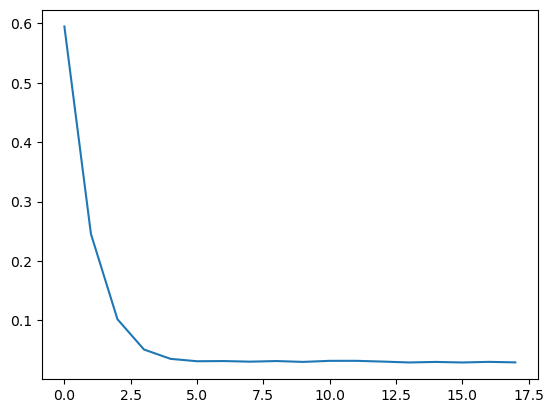

In [101]:
plt.figure()
plt.plot(all_losses_list)
plt.show()